In [1]:
print("strawberry")

strawberry


In [1]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss
import torch.nn as nn

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import torch.distributions as td

from tqdm import tqdm

### Set the seed

In [3]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [4]:
is3D = False

In [5]:
#root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [6]:
domains = [
            wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


# domains = [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]

In [7]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [8]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [9]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2506, 716, 358)

In [11]:
# define dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

### setup model

In [12]:
in_channels = 3
out_channels = 1

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
    model = HyperMapp3r(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   )
    
    
    optimizer_params={"lr":2e-3}
    lr_scheduler_params={"step_size":20, "gamma":0.1}
    # optimizer_params={"lr":2e-3, "momentum":0.6}
    # optimizer = torch.optim.RMSprop
    # lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    # lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [13]:
summary(model, (1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
HyperMapp3r                              --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-3                        --                        --
├─ModuleList: 1-4                        --                        --
├─ModuleList: 1-5                        --                        --
├─ModuleList: 1-2                        --                        --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           448
├─ModuleList: 1-1                        --                        --
│    └─HM3Block: 2-2                     [1, 16, 64, 64]           --
│    │    └─InstanceNorm2d: 3-1          [1, 16, 64, 64]           --
│    │    └─LeakyReLU: 3-2               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-3                  [1, 16, 64, 64]           2,304
│    │    └

In [14]:
loss = dice_loss
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([0.968, 0.032]))
#loss = FocalLoss(gamma=1., reduction='mean', alpha=torch.Tensor([1-0.968, 1-0.032]))
#loss = log_cosh_dice_loss
#loss = TverskyLoss(beta=0.7)
#loss = FocalTverskyLoss(beta=0.7, gamma=0.8)

In [15]:
optimizer_params={"lr":2e-4, "momentum":0.6}
optimizer = torch.optim.RMSprop
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [16]:
# model = StandardLitModelWrapper(model, loss, 
#                                 logging_metric=lambda : None,
#                                 optimizer_params=optimizer_params,
#                                 lr_scheduler_params=lr_scheduler_params,
#                                 is_uq_model=False,
#                                 optimizer_constructor=optimizer,
#                                 lr_scheduler_constructor=lr_scheduler_constructor
#                                )
checkpoint="epoch=38-step=1560.ckpt"
model = StandardLitModelWrapper.load_from_checkpoint(checkpoint, model=model, loss=loss, logging_metric = lambda : None)

In [17]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### train

In [18]:
# trainer.fit(model, train_dataloader, val_dataloader)

In [19]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.20572760701179504
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.20572760701179504}]

In [20]:
x1, y1 = next(iter(val_dataloader))

In [21]:
with torch.no_grad():
    model.eval()
    y_hat = model(x1.to(model.device))

In [22]:
y1.shape, y_hat.shape, x1.shape

(torch.Size([8, 224, 160]),
 torch.Size([8, 2, 224, 160]),
 torch.Size([8, 3, 224, 160]))

In [23]:
torch.max(x1)

tensor(5.6490)

In [24]:
dice_loss(y_hat, y1)


tensor(0.3567)

In [25]:
TverskyLoss(beta=0.7)(y_hat, y1)

tensor(0.3293)

In [26]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    # print(torch.sum(torch.sum(y_true, dim=1) == 0))
    # print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    # print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    # print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    # print(denominator)
    
    return torch.sum((numerator)/ (denominator + 1e-8)) / (s0-ignores) # s0

In [27]:
def slice_dice(y_hat, y_true):
    # print(y_hat.shape)
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    # print(y_hat.shape)
    # print(y_true.shape)
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [28]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [29]:
dice(y_hat, y1)

tensor(0.7433)

In [30]:
actual_dice(y_hat, y1)

tensor(0.4111)

IndexError: index 49 is out of bounds for dimension 0 with size 8

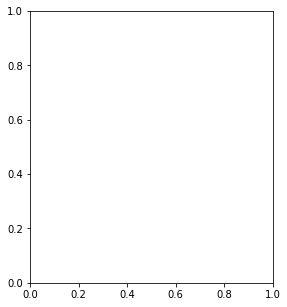

In [31]:
ind = 49
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:])
plt.subplot(1,4,2)
plt.imshow(y1[ind])
plt.subplot(1,4,3)
plt.imshow(y_hat.softmax(dim=1).argmax(dim=1)[ind])
plt.subplot(1,4,4)
plt.imshow(y_hat[ind][1])
print(slice_dice(y_hat[ind], y1[ind]))
plt.show()

### Glow normalizing flow

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from math import log, pi, exp
import numpy as np
from scipy import linalg as la

logabs = lambda x: torch.log(torch.abs(x))


class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()

        self.loc = nn.Parameter(torch.zeros(1, in_channel, 1, 1))
        self.scale = nn.Parameter(torch.ones(1, in_channel, 1, 1))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            flatten = input.permute(1, 0, 2, 3).contiguous().view(input.shape[1], -1)
            mean = (
                flatten.mean(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )
            std = (
                flatten.std(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )

            self.loc.data.copy_(-mean)
            self.scale.data.copy_(1 / (std + 1e-6))

    def forward(self, input):
        _, _, height, width = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)

        log_abs = logabs(self.scale)

        logdet = height * width * torch.sum(log_abs)

        if self.logdet:
            return self.scale * (input + self.loc), logdet

        else:
            return self.scale * (input + self.loc)

    def reverse(self, output):
        return output / self.scale - self.loc


class InvConv2d(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        weight = torch.randn(in_channel, in_channel)
        q, _ = torch.qr(weight)
        weight = q.unsqueeze(2).unsqueeze(3)
        self.weight = nn.Parameter(weight)

    def forward(self, input):
        _, _, height, width = input.shape

        out = F.conv2d(input, self.weight)
        logdet = (
            height * width * torch.slogdet(self.weight.squeeze().double())[1].float()
        )

        return out, logdet

    def reverse(self, output):
        return F.conv2d(
            output, self.weight.squeeze().inverse().unsqueeze(2).unsqueeze(3)
        )


class InvConv2dLU(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        weight = np.random.randn(in_channel, in_channel)
        q, _ = la.qr(weight)
        w_p, w_l, w_u = la.lu(q.astype(np.float32))
        w_s = np.diag(w_u)
        w_u = np.triu(w_u, 1)
        u_mask = np.triu(np.ones_like(w_u), 1)
        l_mask = u_mask.T

        w_p = torch.from_numpy(w_p)
        w_l = torch.from_numpy(w_l)
        w_s = torch.from_numpy(w_s)
        w_u = torch.from_numpy(w_u)

        self.register_buffer("w_p", w_p)
        self.register_buffer("u_mask", torch.from_numpy(u_mask))
        self.register_buffer("l_mask", torch.from_numpy(l_mask))
        self.register_buffer("s_sign", torch.sign(w_s))
        self.register_buffer("l_eye", torch.eye(l_mask.shape[0]))
        self.w_l = nn.Parameter(w_l)
        self.w_s = nn.Parameter(logabs(w_s))
        self.w_u = nn.Parameter(w_u)

    def forward(self, input):
        _, _, height, width = input.shape

        weight = self.calc_weight()

        out = F.conv2d(input, weight)
        logdet = height * width * torch.sum(self.w_s)

        return out, logdet

    def calc_weight(self):
        weight = (
            self.w_p
            @ (self.w_l * self.l_mask + self.l_eye)
            @ ((self.w_u * self.u_mask) + torch.diag(self.s_sign * torch.exp(self.w_s)))
        )

        return weight.unsqueeze(2).unsqueeze(3)

    def reverse(self, output):
        weight = self.calc_weight()

        return F.conv2d(output, weight.squeeze().inverse().unsqueeze(2).unsqueeze(3))


class ZeroConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, padding=1):
        super().__init__()

        self.conv = nn.Conv2d(in_channel, out_channel, 3, padding=0)
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()
        self.scale = nn.Parameter(torch.zeros(1, out_channel, 1, 1))

    def forward(self, input):
        out = F.pad(input, [1, 1, 1, 1], value=1)
        out = self.conv(out)
        out = out * torch.exp(self.scale * 3)

        return out


class AffineCoupling(nn.Module):
    def __init__(self, in_channel, filter_size=512, affine=True):
        super().__init__()

        self.affine = affine

        self.net = nn.Sequential(
            nn.Conv2d(in_channel // 2, filter_size, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_size, filter_size, 1),
            nn.ReLU(inplace=True),
            ZeroConv2d(filter_size, in_channel if self.affine else in_channel // 2),
        )

        self.net[0].weight.data.normal_(0, 0.05)
        self.net[0].bias.data.zero_()

        self.net[2].weight.data.normal_(0, 0.05)
        self.net[2].bias.data.zero_()

    def forward(self, input):
        in_a, in_b = input.chunk(2, 1)

        if self.affine:
            log_s, t = self.net(in_a).chunk(2, 1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # out_a = s * in_a + t
            out_b = (in_b + t) * s

            logdet = torch.sum(torch.log(s).view(input.shape[0], -1), 1)

        else:
            net_out = self.net(in_a)
            out_b = in_b + net_out
            logdet = None

        return torch.cat([in_a, out_b], 1), logdet

    def reverse(self, output):
        out_a, out_b = output.chunk(2, 1)

        if self.affine:
            log_s, t = self.net(out_a).chunk(2, 1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # in_a = (out_a - t) / s
            in_b = out_b / s - t

        else:
            net_out = self.net(out_a)
            in_b = out_b - net_out

        return torch.cat([out_a, in_b], 1)


class Flow(nn.Module):
    def __init__(self, in_channel, affine=True, conv_lu=True):
        super().__init__()

        self.actnorm = ActNorm(in_channel)

        if conv_lu:
            self.invconv = InvConv2dLU(in_channel)

        else:
            self.invconv = InvConv2d(in_channel)

        self.coupling = AffineCoupling(in_channel, affine=affine)

    def forward(self, input):
        out, logdet = self.actnorm(input)
        out, det1 = self.invconv(out)
        out, det2 = self.coupling(out)

        logdet = logdet + det1
        if det2 is not None:
            logdet = logdet + det2

        return out, logdet

    def reverse(self, output):
        input = self.coupling.reverse(output)
        input = self.invconv.reverse(input)
        input = self.actnorm.reverse(input)

        return input


def gaussian_log_p(x, mean, log_sd):
    return -0.5 * log(2 * pi) - log_sd - 0.5 * (x - mean) ** 2 / torch.exp(2 * log_sd)


def gaussian_sample(eps, mean, log_sd):
    return mean + torch.exp(log_sd) * eps


class Block(nn.Module):
    def __init__(self, in_channel, n_flow, split=True, affine=True, conv_lu=True):
        super().__init__()

        squeeze_dim = in_channel * 4

        self.flows = nn.ModuleList()
        for i in range(n_flow):
            self.flows.append(Flow(squeeze_dim, affine=affine, conv_lu=conv_lu))

        self.split = split

        if split:
            self.prior = ZeroConv2d(in_channel * 2, in_channel * 4)

        else:
            self.prior = ZeroConv2d(in_channel * 4, in_channel * 8)

    def forward(self, input):
        b_size, n_channel, height, width = input.shape
        squeezed = input.view(b_size, n_channel, height // 2, 2, width // 2, 2)
        squeezed = squeezed.permute(0, 1, 3, 5, 2, 4)
        out = squeezed.contiguous().view(b_size, n_channel * 4, height // 2, width // 2)

        logdet = 0

        for flow in self.flows:
            out, det = flow(out)
            logdet = logdet + det

        if self.split:
            out, z_new = out.chunk(2, 1)
            mean, log_sd = self.prior(out).chunk(2, 1)
            log_p = gaussian_log_p(z_new, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)

        else:
            zero = torch.zeros_like(out)
            mean, log_sd = self.prior(zero).chunk(2, 1)
            log_p = gaussian_log_p(out, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)
            z_new = out

        return out, logdet, log_p, z_new

    def reverse(self, output, eps=None, reconstruct=False):
        input = output

        if reconstruct:
            if self.split:
                input = torch.cat([output, eps], 1)

            else:
                input = eps

        else:
            if self.split:
                mean, log_sd = self.prior(input).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = torch.cat([output, z], 1)

            else:
                zero = torch.zeros_like(input)
                # zero = F.pad(zero, [1, 1, 1, 1], value=1)
                mean, log_sd = self.prior(zero).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = z

        for flow in self.flows[::-1]:
            input = flow.reverse(input)

        b_size, n_channel, height, width = input.shape

        unsqueezed = input.view(b_size, n_channel // 4, 2, 2, height, width)
        unsqueezed = unsqueezed.permute(0, 1, 4, 2, 5, 3)
        unsqueezed = unsqueezed.contiguous().view(
            b_size, n_channel // 4, height * 2, width * 2
        )

        return unsqueezed


class Glow(nn.Module):
    def __init__(
        self, in_channel, n_flow, n_block, affine=True, conv_lu=True
    ):
        super().__init__()

        self.blocks = nn.ModuleList()
        n_channel = in_channel
        for i in range(n_block - 1):
            self.blocks.append(Block(n_channel, n_flow, affine=affine, conv_lu=conv_lu))
            n_channel *= 2
        self.blocks.append(Block(n_channel, n_flow, split=False, affine=affine))

    def forward(self, input):
        log_p_sum = 0
        logdet = 0
        out = input
        z_outs = []

        for block in self.blocks:
            out, det, log_p, z_new = block(out)
            z_outs.append(z_new)
            logdet = logdet + det

            if log_p is not None:
                log_p_sum = log_p_sum + log_p

        return log_p_sum, logdet, z_outs

    def reverse(self, z_list, reconstruct=False):
        for i, block in enumerate(self.blocks[::-1]):
            if i == 0:
                input = block.reverse(z_list[-1], z_list[-1], reconstruct=reconstruct)

            else:
                input = block.reverse(input, z_list[-(i + 1)], reconstruct=reconstruct)

        return input

In [7]:
glow = Glow(2, 8, 2)

In [8]:
summary(glow)

Layer (type:depth-idx)                                  Param #
Glow                                                    --
├─ModuleList: 1-1                                       --
│    └─Block: 2-1                                       --
│    │    └─ModuleList: 3-1                             2,549,056
│    │    └─ZeroConv2d: 3-2                             304
│    └─Block: 2-2                                       --
│    │    └─ModuleList: 3-3                             2,994,816
│    │    └─ZeroConv2d: 3-4                             4,672
Total params: 5,548,616
Trainable params: 5,548,616
Non-trainable params: 0

In [34]:
summary(glow, (1, 2, 224//2, 160//2))

/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Layer (type:depth-idx)                                  Output Shape              Param #
Glow                                                    --                        --
├─ModuleList: 1-1                                       --                        --
│    └─Block: 2                                         --                        --
│    │    └─ModuleList: 3-1                             --                        5,098,112
│    └─Block: 2                                         --                        --
│    │    └─ModuleList: 3-2                             --                        5,989,632
│    └─Block: 2-1                                       [1, 4, 56, 40]            --
│    │    └─ZeroConv2d: 3-3                             [1, 8, 56, 40]            304
│    └─Block: 2-2                                       [1, 16, 28, 20]           --
│    │    └─ZeroConv2d: 3-4                             [1, 32, 28, 20]           4,672
Total params: 11,092,296
Trainable params:

In [35]:
class GlowWrapper(nn.Module):
    def __init__(self, encoder, glow_model):
        super().__init__()
        self.enc = encoder
        self.nf = glow_model
        
    def forward(self, x):
        with torch.no_grad():
            features = self.enc(x)
            features = torch.nn.functional.interpolate(features, scale_factor=0.5, mode='bilinear')
            
        return self.nf(features)

In [36]:
wrapped = GlowWrapper(model, glow)

In [37]:
optimizer_params={"lr":2e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [38]:
dims = (2, 224, 160)
n_pixel = dims[0] * dims[1] * dims[2]
def calc_loss(out, target):
#     # log_p = calc_log_p([z_list])
#     n_pixel = dims[0] * dims[1] * 

#     loss = -log(n_bins) * n_pixel
#     loss = loss + logdet + log_p
    log_p, logdet, _ = out
    loss = logdet + log_p

    # return (
    #     (-loss / (log(2) * n_pixel)).mean(),
    #     (log_p / (log(2) * n_pixel)).mean(),
    #     (logdet / (log(2) * n_pixel)).mean(),
    # )
    return (-loss / log(2) * n_pixel).mean()

In [39]:
nf = StandardLitModelWrapper(wrapped, calc_loss, 
                                logging_metric=lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )


In [40]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### train

In [41]:
trainer.fit(nf, train_dataloader, val_dataloader)

/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/benp/Documents/Dissertation/Trustworthai-MRI-WMH/trustworthai/models/uq_models/initial_variants/ddu/lightning_logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | GlowWrapper | 13.9 M
--------------------------------------
13.9 M    Trainable params
0         Non-trainable params
13.9 M    Total params
55.468    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from nflows import transforms
import numpy as np
from torchvision.transforms.functional import resize
from nflows.transforms.base import Transform

class Net(nn.Module):

    def __init__(self, in_channel, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 1),
            nn.ReLU(inplace=True),
            ZeroConv2d(64, out_channels),
        )

    def forward(self, inp, context=None):
        return self.net(inp)


def getGlowStep(num_channels, crop_size, i):
    mask = [1] * num_channels
    
    if i % 2 == 0:
        mask[::2] = [-1] * (len(mask[::2]))
    else:
        mask[1::2] = [-1] * (len(mask[1::2]))

    def getNet(in_channel, out_channels):
        return Net(in_channel, out_channels)

    return transforms.CompositeTransform([
        transforms.ActNorm(num_channels),
        transforms.OneByOneConvolution(num_channels),
        transforms.coupling.AffineCouplingTransform(mask, getNet)
    ])



def getGlowScale(num_channels, num_flow, crop_size):
    z = [getGlowStep(num_channels, crop_size, i) for i in range(num_flow)]
    return transforms.CompositeTransform([
        transforms.SqueezeTransform(),
        *z
    ])


def getGLOW():
    num_channels = 1 * 4
    num_flow = 32
    num_scale = 3
    crop_size = 28 // 2
    transform = transforms.MultiscaleCompositeTransform(num_scale)
    for i in range(num_scale):
        next_input = transform.add_transform(getGlowScale(num_channels, num_flow, crop_size),
                                             [num_channels, crop_size, crop_size])
        num_channels *= 2
        crop_size //= 2

    return transform

Glow_model = getGLOW()

NameError: name 'ZeroConv2d' is not defined

In [3]:
summary(Glow_model)

NameError: name 'Glow_model' is not defined

In [60]:
a = torch.randn(1, 4, 28, 28)

In [64]:
Glow_model.sample

AttributeError: 'MultiscaleCompositeTransform' object has no attribute 'sample'

In [63]:
help(Glow_model)

Help on MultiscaleCompositeTransform in module nflows.transforms.base object:

class MultiscaleCompositeTransform(Transform)
 |  MultiscaleCompositeTransform(num_transforms, split_dim=1)
 |  
 |  A multiscale composite transform as described in the RealNVP paper.
 |  
 |  Splits the outputs along the given dimension after every transform, outputs one half, and
 |  passes the other half to further transforms. No splitting is done before the last transform.
 |  
 |  Note: Inputs could be of arbitrary shape, but outputs will always be flattened.
 |  
 |  Reference:
 |  > L. Dinh et al., Density estimation using Real NVP, ICLR 2017.
 |  
 |  Method resolution order:
 |      MultiscaleCompositeTransform
 |      Transform
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, num_transforms, split_dim=1)
 |      Constructor.
 |      
 |      Args:
 |          num_transforms: int, total number of transforms to be added.
 |        